## Post process analysis
- Load the turn by turn data
- Emittance evolution 
- Tune shift with amplitude

In [1]:
import os
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
from dotted_dict import DottedDict
import pickle
import PyNAFF as pnf
sys.path.append('./utils')
from my_functions import *

### Plotting parameters

In [2]:
params = {'legend.fontsize': 12,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 18,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Study parameters

In [3]:
f_rev = 11.2455e3  # revolution frequency [Hz]
# Relativistic parameters
gamma_rel = 7460.52252807237 # from madx twiss
beta_rel = sqrt(1-(1/gamma_rel)**2)
# Twiss parameters
twiss = DottedDict()
twiss.beta_x = 115.75 #at IP3 #obtained from madx twiss. should be crossed check
twiss.beta_y = 1. 
twiss.alpha_x = 0 
twiss.alpha_y = 0 
twiss.gamma_x = (1+twiss.alpha_x**2)/twiss.beta_x
twiss.gamma_y = (1+twiss.alpha_y**2)/twiss.beta_y
ex_norm = 2.5e-6
ex_geom = ex_norm/(beta_rel*gamma_rel)
#ex_geom = 0.047#*1e-9 #for SCC
sigma_x = sqrt(twiss.beta_x*ex_geom)
sigma_px = sqrt(ex_geom/twiss.beta_x)
print(sigma_x, sigma_px)
particles = 15000
turns = 1000

0.00019694541882215593 1.7014723008393603e-06


### Parameters of interest, in beam sigma px

In [4]:
gain_values = [0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5] ## BB parameter
ksi = 0.01
delta = 0.05
A = 3. 

### Calculate the emittance values with time for each one of the studies

In [6]:
ex_dictionary = {}

for gain_value in gain_values:
    df = pd.read_pickle('./turn_by_turn_data/Qx0.78_noise{}_BB{}_feedback{}_betax115.75_H_particles15000_turns1000.pkl'.format(delta, ksi, gain_value))
    ex_dictionary['gain'+str(gain_value)] = [] # the name of the list on the dicitonary indicates the values of the BB parameter and of the strength noise
    for turn in range(turns):
        ex_dictionary['gain'+str(gain_value)].append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))

### Apply linear fit at the emitance values of each study.
During the first turns a flactuation of the emittance values is observed due to mismatched beam. Therfore the first 200 turns are excluded from the fit

No handles with labels found to put in legend.


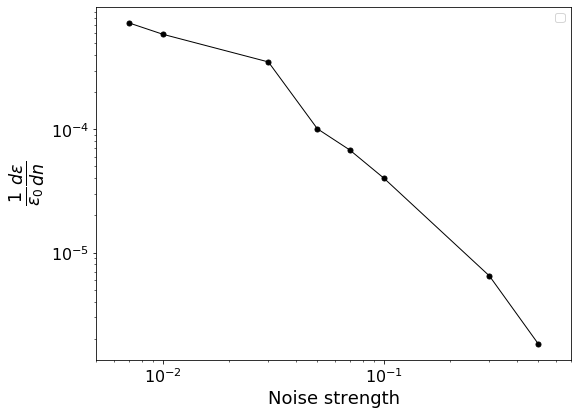

In [16]:
fig, ax = plt.subplots()

turns_list = np.arange(0,turns)
rate_list = []

for gain_value in gain_values:

    current_study = ex_dictionary['gain'+str(gain_value)]
    [m_h,b_h], cov_h = np.polyfit(turns_list, current_study/current_study[0], 1, cov= True)
    rate_list.append(m_h)
    
    #ax.plot(gain_value, m_h, marker = 'o', c = 'k', linestyle='-')
ax.plot(gain_values, rate_list, 'ok-')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Noise strength')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)
ax.set_xlim(0.005, 0.7)
#plt.legend()
#plt.savefig('./figures/emittance_growth_rate_Qx0.78_noise0.05_BB0.01_feedbackScan_betax115.75_H_particles15000_turns1000.png')

### Compare emittance growth rate with the expected rate

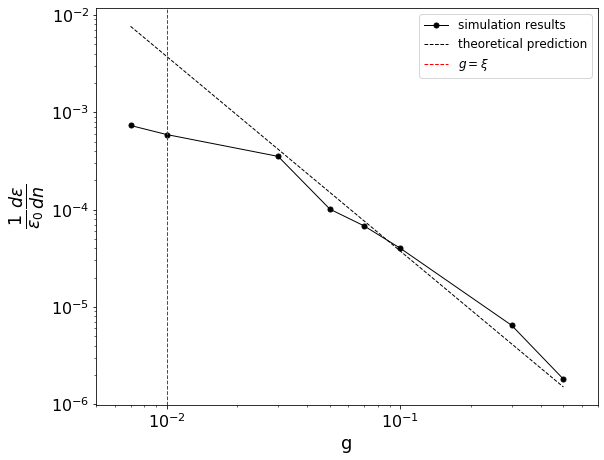

In [22]:
fig, ax = plt.subplots()

turns_list = np.arange(0,turns)
growth_rate = []
theory_rate = []

for gain_value in gain_values:

    current_study = ex_dictionary['gain'+str(gain_value)]
    [m_h,b_h], cov_h = np.polyfit(turns_list, current_study/current_study[0], 1, cov= True)
    growth_rate.append(m_h)
    theory_rate.append(A*((ksi**2)*((delta**2))/(2*gain_value**2)))

ax.plot(gain_values, growth_rate, 'ok-', label = 'simulation results')
ax.plot(gain_values, theory_rate, c = 'k', linestyle = '--', label = 'theoretical prediction')      
ax.axvline(x=ksi, c = 'r', linestyle = '--', label = r'$g = \xi$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('g')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)
ax.set_xlim(0.005, 0.7)

plt.legend()
plt.tight_layout()
plt.savefig('./figures/emittance_growth_rate_Qx0.78_noise0.05_BB0.01_feedbackScan_betax115.75_H_particles15000_turns1000.png')